# VQEを利用した分子シミュレーション

このチュートリアルでは、Variational Quantum Eigensolver (VQE)とその利用の狙いを紹介し、必要な理論を説明します。また、分子の基底状態エネルギーを見つけるための実装例を紹介します。

## はじめに

多くのアプリケーションでは、行列の最小固有値を見つけることが重要です。例えば、化学では、分子を特徴付けるエルミート行列の最小固有値は、その系の基底状態のエネルギーになります。将来的には、最小固有値を見つけるのに量子位相推定アルゴリズムが使われる見込みですが、実用的な問題に対する実装に必要な回路の深さは、NISQ時代に利用可能なハードウェアの限界を超えている状態です。それゆえに、2014年にPeruzzoらが、十分深さの浅い回路を利用して分子の基底状態エネルギーを推定するために VQE を提唱しました[1]。

正式に言えば、固有状態$|\psi_{\text{min}}\rangle$に関連付けられた未知の最小固有値$\lambda_{\text{min}}$を持つエルミート行列$H$が与えられると、VQEは$\lambda_{\text{min}}$を境界とした推定値$\lambda_{\theta}$を求めます。

$$ \begin{aligned} \lambda_{\text{min}} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle \end{aligned}<br> $$

ここで、$|\psi(\theta)\rangle$は、$\lambda_{\theta}$に紐づいた固有状態です。 $U(\theta)$で表されるパラメーター化された回路を任意の初期状態$|\psi\rangle$に適用することにより、アルゴリズムは$|\psi_{\text{min}}\rangle$において推定値$U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$を取得します。推定は、パラメーター$\theta$を変更する古典的なコントローラーによって繰り返し最適化され、期待値$\langle \psi(\theta) |H|\psi(\theta) \rangle$が最小化されます。


## 量子力学における変分法

### 数学的背景

VQEは、量子力学の変分法を応用したものです。変分法をより理解するために、基礎的な数学的背景を説明します。行列 $A$ の固有ベクトル $|\psi_i\rangle$ は、$A$ による変換ではスカラー乗数($A$ の固有値$\lambda_i$)分の違いだけしか変化しません。すなわち、

$$
\begin{aligned}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{aligned}
$$

さらに行列 $H$ が随伴行列(自身と複素共役転置が等しい)の場合は、エルミート行列となります。

$$ \begin{aligned} H = H^{\dagger} \end{aligned} $$

スペクトル定理によると、エルミート行列の固有値は実数になります。したがって、$H$ の任意の固有値は  `{latex} \lambda_i = \lambda_i^*` を満たします。測定できる量は実数である必要があるため、量子系のハミルトニアンを記述するにはエルミート行列が適切です。さらには、$H$ は以下のように表現できます。

$$ \begin{aligned} H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i | \end{aligned} $$

ここで、各 $\lambda_i$ は、対応する固有ベクトル $|\psi_i\rangle$ の固有値です。また、任意の量子状態$|\psi\rangle$に対するオブザーバブル $H$ の期待値は、以下の式で求められます。

$$
\begin{aligned}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{aligned}
$$

$H$ を重み付きの固有ベクトルの和として代入すると、次のようになります。

$$
\begin{aligned}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$


最後の式は、任意の状態に対するオブザーバブルの期待値は、$H$ に関係する固有値を利用して重みのついた線形結合として示せることを表しています。さらには、$| \langle \psi_i | \psi\rangle |^2 \ge 0$ であるため、線型結合における重みは 0以上の数値になるので、次は自明です。

$$ \begin{aligned} \lambda_{\text{min}} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2 \end{aligned} $$

上記の方程式は**変分法**として知られています（一部のテキストでは変分原理としても知られています）[2]。これは、波動関数の期待値が常に少なくとも$H$に関連付けられた最小固有値になることを意味することに注意することが重要です。さらに、固有状態$|\psi_{\text{min}}\rangle$の期待値は、 `{latex} \langle \psi_{\text{min}}|H|\psi_{\text{min}}\rangle = \langle \psi_{\text{min}}|\lambda_{\text{min}}|\psi_{\text{min}}\rangle = \lambda_{\text{min}}`で与えられます。したがって、予想どおり、  `{latex} \langle H \rangle_{\psi_{\text{min}}}=\lambda_{\text{min}}`となります。

### 基底状態の下限

系のハミルトニアンがエルミート行列$H$で記述される場合、その系の基底状態エネルギー $E_{gs}$ は $H$ に紐づいた最小固有値です。波動関数$|\psi \rangle$（ *ansatz* と呼ばれる）を $ |\psi_{\text{min}}\rangle$ に近似する初期推定値として任意に選択し、その期待値 $\langle H \rangle_{\psi}$ を計算します。そして波動関数を繰り返し更新することで、ハミルトニアンの基底状態エネルギーの任意の正確な下限を得ることができます。 

## 変分量子固有値ソルバー

### 変分形式

量子コンピューターに変分法を実装するには、ansatzを変化させる体系的なアプローチが必要です。 VQEは固定形式のパラメーター化された回路を使用してこれを行います。このような回路は*変分形式*と呼ばれることが多く、その作用は線形変換$U(\theta)$で表すことができます。変分形式は始状態$|\psi\rangle$（真空状態$|0\rangle$やHartreeFock状態など）に適用され、出力状態$U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$を生成します。 $|\psi(\theta)\rangle$に対する反復最適化は、期待値`{latex} \langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{\text{min}}`を生成することを目的としています。 理想的には、 $|\psi(\theta)\rangle$ は $|\psi_{\text{min}}\rangle$ に近くなります（ここで、「近さ」は状態の忠実度またはマンハッタン距離のいずれかによって特徴付けられます）。 そうでない場合でも、 $E_{gs}$ の有用な境界を取得できます。

さらには、多項式オーダーの数だけパラメーターをもった固定変分形式は、指数関数サイズのヒルベルト空間内の全ての状態を、多項式サイズの部分空間へ変換のみします。その結果として、様々な変分形式があります。いくつか、例えば、Ry や RyRz は目的とするドメインを考慮せず、いわば発見的に設計されたものがあります。その他、UCCSD などは、問題の構造に基づいて近似を生成するために、特定のドメイン知識を利用しています。よく利用される変分形式の構造は、このドキュメントの後半で詳しく説明します。

### 単純な変分形式

変分形式を構築する際には、２つの相反する目的のバランスを考える必要があります。理想的には、$n$ 量子ビットの変分形式は、$|\psi\rangle \in \mathbb{C}^N$ かつ $N=2^n$の任意の状態 $|\psi\rangle$ を生成できます。しかしながら、可能な限り少ないパラメーターで変分形式を構築したいです。ここでは簡単のため、最初のゴールを満たして２つめのゴールを満たさない変分形式の構築の勘所を掴むことを目的とします。

$n=1$ の場合を考えます。U3 ゲートは３つのパラメーター$\theta, \phi$ および $\lambda$ を受け取り、以下の変換を表現します:

$$
\begin{aligned}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{aligned}
$$

グローバル位相を除いて、これらのパラメーターを適切に設定することにより、どんな取り得る単一量子ビット変換も実装できます。したがって、単一量子ビットの場合、どんな取り得る状態でも生成できる変分形式が回路によって与えられます。

<img src="./images/U3_var_form.png" alt="U3 Variational Form" width="350">

さらに、この普遍的な「変分形式」には3つのパラメーターしかないため、効率的に最適化できます。ここで強調する価値のあることとして、任意の状態を生成する能力によって、最適化プロセスにおいて、変分形式は$H$の期待値をとり得る状態のセットを制限しないことが保証されるということです。理想的には、これにより、最小期待値は古典オプティマイザーの能力によってのみ制限されることが保証されます。

あまり自明でない普遍的な変分形式は、２量子ビットの場合から導出できる場合があります。この場合、2体相互作用があるので、普遍性を達成するためには、エンタングルメントを考慮に入れる必要があります。*Shende et al.* [3] によると、以下の例が2量子ビットの普遍的なパラメーター化された量子回路になります。

<img src="./images/two_qubit_var_form.png" alt="Two Qubit Variational Form" width="800">

上記の回路によって実行される変換が$U(\theta)$で表現されるようにします。変分的に最適化すると、$H$の期待値が最小となるのは$U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{\text{min}}\rangle$のときです。定式化することで$U(\theta)$は任意の取り得る状態への変換を生成する可能性があるため、この変分形式は、古典的なオプティマイザーの能力によってのみ制限される、2量子ビットの基底状態エネルギーの任意の正確な下限を得ることができます。

### パラメーター最適化

効率的にパラメータ化された変分形式を選択したら、変分法に従って、そのパラメーターをターゲットとなるハミルトニアンの期待値を最小化するように最適化する必要があります。パラメーターの最適化のプロセスには様々な課題があります。例えば、量子ハードウェアには様々なタイプのノイズがあり、目的関数の評価(エネルギーの計算）は実際の目的関数を反映しないかも知れません。また、オプティマイザーによってはパラメーターの数に依存して、目的関数の評価を数多く実施します。アプリケーションの要件を考慮しながら、最適なオプティマイザーを選択する必要があります。

もっとも一般的な最適化戦略は最急降下法です。再急降下法はエネルギーの変化が極大になるような方向にパラメータを更新する方法です。結果として、評価の回数は、最適化するパラメーターの数に依存します。これにより、探索空間において局所最適解を高速に発見するアルゴリズムとなります。しかしながら、この最適化方法はしばしば局所最適時に留まることがあり、実施される回路評価数という観点で比較的計算コストが高いです。直感的な最適化戦略ですが、VQEで利用するにはお勧めできません。

ノイズのある目的関数を最適化する適切なオプティマイザーとして、*Simultaneous Perturbation Stochastic Approximation* オプティマイザー (SPSA)があります。SPSAは２回の測定だけで、目的関数の勾配を近似します。最急降下法では各パラメーターに対して独立に摂動を与えるのに対して、SPSAは全てのパラメーターに対して同時にランダムな摂動を与えます。VQEをノイズ込みのシミュレーター、もしくは実ハードウェアで利用する場合には、SPSAは古典オプティマイザーとして推奨されます。

コスト関数の評価にノイズがない場合（例えば、VQEを状態ベクトルシミュレーターで利用する場合など）は、多様な古典オプティマイザーを利用できます。Qiskit Aqua でサポートされている２つのオプティマイザーは、*Sequential Least Squares Programming* オプティマイザー (SLSQP) と *Constrained Optimization by Linear Approximation* オプティマイザー (COBYLA) です。COBYLAの注目に値する点は、最適化計算の繰り返しにおいて目的関数の評価は１度だけ（つまり評価の回数はパラメーターの数に依存しない）ということです。従って、目的関数がノイズがない場合、及び評価の回数を最小化したい場合は、COBYLAの利用が推奨されます。

### 単一量子ビットの変分形式の例

ではここで、基底エネルギー推定問題と似たようなシンプルな単一量子ビットの変分形式を利用してみます。具体的には、ランダムな確率ベクトル$\vec{x}$ が与えられており、出力の確率分布が $\vec{x}$ に近くなる（ここで近さとは２つの確率ベクトル間のマンハッタン距離によって定義します）ように、可能な単一量子ビット変分形式のパラメーターを決定したいです。

最初に python でランダム確率ベクトルを作成します。

In [1]:
# pylint: disable=missing-function-docstring
import numpy as np
np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1-p0}

次に、単一の U3 変分形式の３つのパラメーターを引数として受け取り、対応する量子回路を返す関数を定義します。

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

次に変分形式のパラメーターのリストを入力とし、パラメーターに対応したコストを計算する目的関数を定義します。

In [3]:
from qiskit import Aer
backend = Aer.get_backend("aer_simulator")

def counts_to_distr(counts):
    """Convert Qiskit result counts to dict with integers as
    keys, and pseudo-probabilities as values."""
    n_shots = sum(counts.values())
    return {int(k, 2): v/n_shots for k, v in counts.items()}

def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = get_var_form(params)
    result = backend.run(qc).result()
    # Get the counts for each measured state, and convert
    # those counts into a probability dict
    output_distr = counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

最後に、COBYLA オプティマイザーのインスタンスを作成し、アルゴリズムを実行します。出力は実行の度に異なることに注意してください。また、近いとはいえ、得られた分布はターゲットの分布とは完全に同じではありません。しかしながら、ショットの数を増やすことで出力の精度を向上させることができるでしょう。

In [4]:
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
params = np.random.rand(3)
result = optimizer.minimize(
    fun=objective_function,
    x0=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distr = counts_to_distr(counts)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))

Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.5168, 0.4832]
Output Error (Manhattan Distance): 0.003140118738839126
Parameters Found: [1.55029302 0.76612133 0.64945506]


### 一般的な変分形式の構造

既に説明したように、多項式パラメーターの変分形式では、任意の状態への変換を生成できません。変分形式はこの制限をどのように扱うかによって２つのカテゴリーに分類されます。変分形式の最初のカテゴリーはドメイン、あるいはアプリケーション固有の知識を生かして可能な出力状態のセットを制限するというものです。２つ目は、ドメインやアプリケーション固有の知識なしに、発見的な回路を利用するアプローチです。

最初のカテゴリーの変分形式は、必要となる変換のセットを制限するために、課題ドメインの特徴を利用します。例えば、分子の基底状態エネルギーの計算には、粒子の数は*前もって*知られているとします。従って、正しい粒子数をもった始状態を利用していれば、変分形式を粒子数を保存する変換にのみ制限することで、新しい変換の部分空間への展開に必要なパラメーター数を大きく削減することができます。実際に、結合クラスター(Coupled-Cluster)理論と同じような情報を利用することで、変分形式UCCSD は、Hartree Fock状態から開始する場合、分子の基底状態エネルギー値を非常に正確に推定することが出来ます。ドメイン固有の知識を利用する別の例として、実量子ハードウェアで実現可能な回路を考慮するというものが挙げられます。超電導型量子ビットに基づくような現存する量子コンピューターは量子ビット間接続に制限があります。つまり、(スワップゲートを挟み込むことなく）任意の量子ビットペアに基づく、２量子ビットゲートを実装することが出来ません。与えられた利用可能な接続性とゲートを最大限活用した回路により特定の量子コンピューターに特化した変分形式の構築がなされています。このような変分形式により 2017年にIBMの量子コンピューター上で、 BeH$_2$ までの大きさをもつ分子の基底状態エネルギーの推定をするVQE実装に成功しました[4]。

２番目のアプローチでは、広範囲の状態に対してよい近似が得られるようにゲートをレイヤー化します。Qiskit Aqua では、３つのこのような変分形式: RyRz、Ry、及び SwapRzをサポートしています（ここでは最初の２つのみ説明します）。これらの変分形式はすべて、複数のユーザーが指定する設定を受け付けます。３つの不可欠な設定は、システム上の量子ビット数、深さの設定、及びエンタグルメント設定です。変分形式の一つのレイヤーでは、特定のパターンの単一量子ビットの回転と CX ゲートを指定します。深さの設定では、例えば、変分形式がこのパターンを何回繰り返すかを指定します。深さを増やすことで、最適化すべきパラメーター数を増やすことで生じるコストが上がりますが、変分形式が生成できる状態のセットも増加します。最後に、エンタングルメント設定は、CXゲートの構成、つまり数を選択します。例えば、エンタングルメント設定が linear の場合、CXゲートは順番に直近の量子ビットペアに適用されます（したがって$n-1$ CX ゲートがレイヤーに追加されます）。エンタングルメント設定が full の場合、CXゲートは、各レイヤーのそれぞれの量子ビットペアに適用されます。`entanglement="full"` と `entanglement="linear"`の場合の、RxRz回路は以下のコードを実行することで確認できます。

linear entanglement:


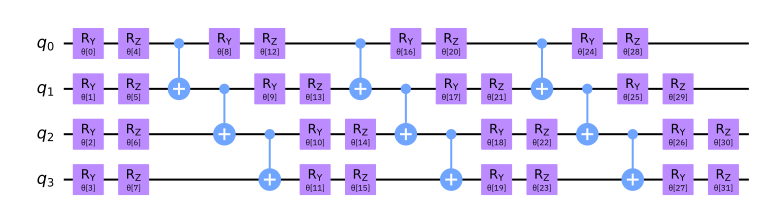

full entanglement:


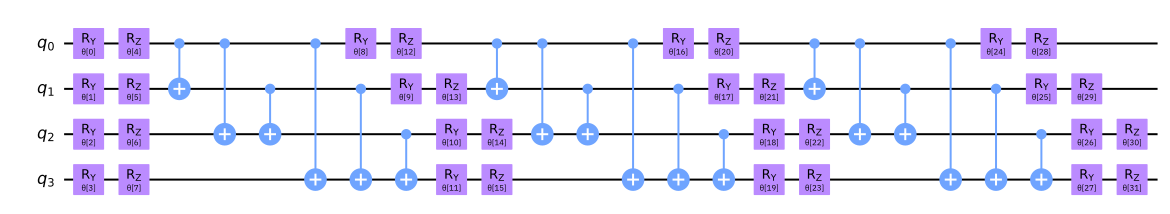

In [5]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw(fold=-1))

深さの設定を $d$ とします。この時、RyRz は $2n\times (d+1)$ 個のパラメーターを持ち、Ry(表示されていません)は$n\times (d+1)$個のパラメーターを持ちます。

## Qiskit での VQE 実装

このセクションでは、プログラミングアプローチでのVQEの実装を示します。Qiskit Aqua では宣言的な実装もできますが、この場合動作しているアルゴリズムの情報が表面に出てきません。このコードは、特に量子ビット操作の準備は、Qiskit チュートリアルリポジトリに基づいています(リポジトリは 2019年7月の時点で https://github.com/Qiskit/qiskit-tutorials　にあります）。

次のライブラリを最初にインポートします。


In [6]:
# pylint: disable=line-too-long
import matplotlib.pyplot as plt
import qiskit
from qiskit.algorithms import VQE
import qiskit_nature
import qiskit_nature.problems.second_quantization
import qiskit_nature.drivers.second_quantization
import qiskit_nature.transformers.second_quantization.electronic
import qiskit_nature.algorithms
from qiskit_nature.drivers import Molecule

/var/folders/z_/6s4ntyps5lsb232v7f82201r0000gn/T/ipykernel_22101/2068492128.py:22: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation import CompleteMeasFitter


### VQE を状態ベクトルシミュレーターで実行する

様々な原子間距離での LiH の基底エネルギーの計算を実行してみます。各距離について分子ドライバーを作成する必要があります。この実験では、利用する量子ビットの数を減らすため、内核固定(frozen core)を行い、２つの非占有起動を削除していることに注意してください。最初に、原子間距離を引数とし、適切な量子ビット演算子 $H$ と演算子に関するその他の情報を返す関数を定義します。

In [7]:
def get_qubit_op(molecule,remove_orbitals):
    driver = qiskit_nature.drivers.second_quantization.ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=qiskit_nature.drivers.second_quantization.ElectronicStructureDriverType.PYSCF)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = qiskit_nature.problems.second_quantization.ElectronicStructureProblem(
        driver,
        remove_orbitals)

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = qiskit_nature.mappers.second_quantization.ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = qiskit_nature.converters.second_quantization.QubitConverter(mapper,two_qubit_reduction=True)
    reducer = qiskit.opflow.TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

最初に、正確な基底状態エネルギーを、量子ビット演算子及び古典固有値ソルバーを使って計算します。次に、初期状態 $|\psi\rangle$ を作成し、これを使って VQE が最終的 ansatz $\min_{\theta}(|\psi(\theta)\rangle)$ を生成するようにします。各原子間距離での正確な値と VQEの結果を記録します。`vqe.run(backend)['energy'] + shift` で与えられる結果と $\min_{\theta}\left(\langle \psi(\theta)|H|\psi(\theta)\rangle\right)$ は同じであることに着目してください。ここでの最小はかならずしも大域的最小ではありません。

`VQE(qubit_op, var_form, optimizer, 'matrix')`を使用してVQEインスタンスを初期化する場合、$|\psi(\theta)\rangle$についての$H$の期待値は、行列の乗算によって直接計算されます。ただし、実際の量子デバイス、または真のシミュレーターである`qasm_simulator`で`VQE(qubit_op, var_form, optimizer, 'paulis')`を使用する場合、期待値の計算はより複雑になります。ハミルトニアンは、パウリ文字列の合計として表すことができ、各パウリ項は、使用されているマッピングによって指定された量子ビットに作用します。各Pauli文字列には、$|\psi(\theta)\rangle$に対応する回路に追加された対応する回路があります。続いて、これらの各回路が実行され、すべての結果を使用して、$|\psi(\theta)\rangle$の $H$ の期待値が決定されます。次の例では、VQEインスタンスを`matrix`モードで初期化するため、期待値は行列の乗算によって直接計算されます。

注意： 以下のコードは完了までしばらく時間がかかります。 

In [8]:
def exact_solver(problem, converter):
    solver = qiskit_nature.algorithms.NumPyMinimumEigensolverFactory()
    calc = qiskit_nature.algorithms.GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = qiskit.BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = qiskit.algorithms.optimizers.SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(molecule,
                                                                [qiskit_nature.transformers.second_quantization.electronic.FreezeCoreTransformer(
                                                                    freeze_core=True,
                                                                    remove_orbitals=[-3,-2])])
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = qiskit_nature.circuit.library.HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = qiskit_nature.circuit.library.UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04751 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50392 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72278 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82516 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86886 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88210 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87917 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86788 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85312 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83763 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82324 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81116 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80195 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79516 Exact Energy: -7.79545
Interatomic Distance

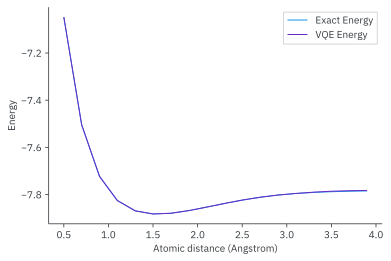

In [9]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

VQEの結果は、正確な値と非常に近いことに着目してください。そのため、正確な値のカーブは VQEカーブに隠れてしまっています。

### VQE をノイズのあるシミュレーターで実行する

ここでは、H$_2$ の基底状態エネルギーの計算に、ノイズのあるシミュレーターとエラー軽減を利用してみます。

最初に、分子のハミルトニアンを表現する量子ビット演算子を用意します。

In [10]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, -0.3625]],
              ["H", [0.0, 0.0, 0.3625]]],
    multiplicity=1,charge=0)

(qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(molecule, None)

次に、デバイスのカップリングマップとノイズモデルを IBMQ プロバイダーからロードし、量子インスタンスを作成し、エラー軽減を有効にします:

In [11]:
from qiskit.providers.fake_provider import FakeManila
from qiskit.providers.aer.noise import NoiseModel # pylint: disable=import-error, no-name-in-module"
backend = Aer.get_backend('aer_simulator')
device = FakeManila()
NOISE_MODEL = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
qi = qiskit.utils.QuantumInstance(backend,
                    coupling_map=coupling_map,
                    noise_model=NOISE_MODEL,
                    measurement_error_mitigation_cls=qiskit.utils.mitigation.CompleteMeasFitter)

最後に、オプティマイザー、変分形式、および VQE インスタンスを構成します。２量子ビット回路の深さが増すにつれて、ノイズの効果が増加するため、ここでは UCCSD ではなく、発見的な変分形式(RYRZ)を利用します。RYRZは、UCCSDに比べ浅い回路で、実質的により少ない２量子ビットゲート回路となります。

注意：以下のコードは完了までしばらく時間がかかります。

In [12]:
result = exact_solver(problem,converter)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = qiskit.algorithms.optimizers.SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
print("VQE Result:", vqe_result)

Exact Result: [-0.93317257]
VQE Result: [-0.93190611]


ノイズ軽減が有効な場合、たとえ結果が化学的精度(正しい結果に対して 0.0016 Hartree 以内と定義されている)になっていませんが、正確な値にかなり近いと言えるでしょう。 

## 問題

1. 基底状態が $n$ 量子ビットの最大にエンタングルしていることがわかっている、ハミルトニアン $H$ が与えられているとします。どの変分形式が、$H$ の基底状態エネルギーを効率的かつ正確に与えるかを説明してください。ここでは自作の変分形式を使っても構いません。その場合、このハミルトニアンになぜそれが適切かを説明してください。
2. COPYLAオプティマイザーと 1000ショットの `qasm_simulator`、および 60パウリ文字列をもったハミルトニアンを使う場合、１回の最適化の際に行われる回路評価数を計算してください。
3. VQEを使って原子間距離が $1.3$Å の BeH$_2$ の基底状態エネルギーを推定してください。`get_qubit_op(dist)` 関数を再利用する場合、`atom="Li .0 .0 .0; H .0 .0 " + str(dist)` を、`atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)` で置き換え、`get_qubit_op(1.3)` を実行してください。この分子の場合、非占有軌道の削除をすると、化学的精度が失われることに注意してください。しかしながら、必要となる量子ビット数を6まで下げる（多くのラップトップで効果的なシミュレーションができるようにする）場合はこの損失は許容範囲です。興味のある読者は、必要な量子ビット数を 7 までにして化学的精度を失わないように試してもよいかもしれません。

## 参考文献

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." *Nature communications* 5 (2014): 4213.
2. Griffiths, David J., and Darrell F. Schroeter. Introduction to quantum mechanics. *Cambridge University Press*, 2018.
3. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits." arXiv preprint quant-ph/0308033 (2003).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242.

In [13]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table

Qiskit Software,Version
qiskit-terra,0.20.2
qiskit-aer,0.9.1
qiskit-ignis,0.7.1
qiskit-ibmq-provider,0.19.1
qiskit-aqua,0.9.5
qiskit,0.36.2
qiskit-nature,0.4.1
qiskit-finance,0.3.2
qiskit-optimization,0.3.2
qiskit-machine-learning,0.4.0
